# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [6]:
## also load all human data into a big dataframe
HD = pd.concat([h.load_and_preprocess_data(p) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

Loaded 120450 lines


### load model data

In [7]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [8]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

/Users/felixbinder/anaconda3/envs/tdw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Loaded 115698 rows


In [9]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [10]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[MD.duplicated(keep="first")]
    print("Removed duplicates")

⚠️There are 18422 duplicated rows!
Removed duplicates


### generate summary table of human 95% CIs for accuracy across all scenarios

In [11]:
## init human_bootstrapped_accuracy for plotting
human_bootstrapped_accuracy = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)
    
    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = h.bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    pct25 = np.percentile(Dacc,2.5)
    pct975 = np.percentile(Dacc,97.5)
    ## merge bootstrapped accuracy estimates
    if len(human_bootstrapped_accuracy)==0:
        human_bootstrapped_accuracy = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()
    else:
        human_bootstrapped_accuracy = pd.concat([human_bootstrapped_accuracy, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()],axis=0)
        
## add column names        
human_bootstrapped_accuracy.columns=['agent','scenario','obs_mean', 'boot_mean', 'ci_lb', 'ci_ub', 'pct_2.5', 'pct_97.5']

## save out human_bootstrapped_accuracy to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_bootstrapped_accuracy.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [12]:
human_bootstrapped_accuracy

,agent,scenario,obs_mean,boot_mean,ci_lb,ci_ub,pct_2.5,pct_97.5
0,human,collision,0.808511,0.808485,0.798793,0.81766,0.704333,0.88
0,human,rollingsliding,0.882986,0.882948,0.875411,0.890696,0.789167,0.94
0,human,dominoes,0.692791,0.6927,0.684341,0.701163,0.614167,0.76
0,human,drop,0.743656,0.743722,0.73541,0.751326,0.666667,0.804667
0,human,clothiness,0.678133,0.678222,0.663729,0.692269,0.543667,0.771667
0,human,linking,0.643182,0.643234,0.631968,0.654545,0.536833,0.744333
0,human,containment,0.766988,0.766892,0.758072,0.775026,0.686667,0.839667
0,human,towers,0.763137,0.763012,0.754975,0.770982,0.669333,0.826


### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



#### Correlation

In [13]:
## init human_boot_corr for plotting
human_boot_corr = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
    
    ## get pairwise correlations
    dists = 1-scipy.spatial.distance.pdist(respMat, metric='correlation')
    corrMat = scipy.spatial.distance.squareform(dists)
    
    ## get percentiles over pairwise corrs
    pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
    lb = np.percentile(pairwiseCorrs, 2.5)
    med = np.percentile(pairwiseCorrs, 50)
    ub = np.percentile(pairwiseCorrs, 97.5)  
        
    if len(human_boot_corr)==0:
        human_boot_corr = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_corr = pd.concat([human_boot_corr, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_corr.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_corr to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_corr.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCorrs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [14]:
human_boot_corr

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.388046,0.62822,0.776057
0,human,rollingsliding,0.506253,0.713836,0.851243
0,human,dominoes,0.231102,0.425943,0.591814
0,human,drop,0.266334,0.501544,0.681139
0,human,clothiness,0.065426,0.349287,0.549326
0,human,linking,0.114636,0.386807,0.569892
0,human,containment,0.306122,0.559038,0.725013
0,human,towers,0.299731,0.565581,0.725722


#### Cohen's $\kappa$

In [15]:
## init human_boot_cohenk for plotting
human_boot_cohenk = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
      
    ## compute Cohen's kappa
    ## with a horrific double loop
    kappas = []
    for i in range(respMat.shape[0]): # for each participant
        for j in range(i+1,respMat.shape[0]): # compare to every participant after them
            assert i != j
            kappa = sklearn.metrics.cohen_kappa_score(respMat[i],respMat[j])
            kappas.append(kappa)
    
    ## get percentiles over pairwise corrs
    lb = np.percentile(kappas, 2.5)
    med = np.percentile(kappas, 50)
    ub = np.percentile(kappas, 97.5)  
        
    if len(human_boot_cohenk)==0:
        human_boot_cohenk = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_cohenk = pd.concat([human_boot_cohenk, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_cohenk.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_cohenk to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_cohenk.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCohensKs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [16]:
human_boot_cohenk

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.381969,0.621826,0.773353
0,human,rollingsliding,0.490152,0.707031,0.85095
0,human,dominoes,0.221083,0.417313,0.586667
0,human,drop,0.260437,0.494367,0.678875
0,human,clothiness,0.062416,0.340571,0.542955
0,human,linking,0.109512,0.369462,0.560538
0,human,containment,0.284806,0.546667,0.719987
0,human,towers,0.285117,0.549918,0.720673


## Visualize distribution of model physical judgments, by domain

In [17]:
MD_by_model = MD.groupby(['filename','Readout Test Data','Model','Dynamics Training Dataset','Readout Type']).agg({'correct':'mean'})
MD_by_model

correct
filename              Readout Test Data Model          Dynamics Training Dataset Readout Type          
dataframe-results.csv clothiness        CSWM           clothiness                A             0.597701
                                                                                 C             0.528736
                                        DEITFrozenLSTM all                       A             0.646067
                                                                                 B             0.583333
                                                                                 C             0.591160
...                                                                                                 ...
                      towers            DEITFrozenMLP  towers                    B             0.655814
                                                                                 C             0.639269
                                        OP3            all                       B             1.000000
                                                                                 C             0.833333
                                                       towers                    C             1.000000

[108 rows x 1 columns]

## Compute summary statistics over model physical judgments, by domain

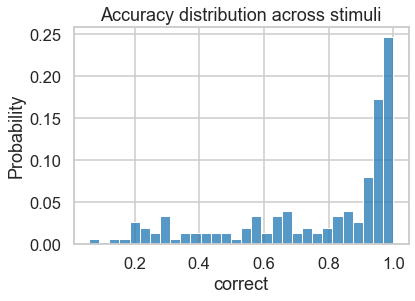

In [18]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

In [19]:
# group model data by scenario
MD_by_scenario = MD.groupby(['Readout Test Data','ModelID']).agg(
{
    'correct':'mean'
})

In [20]:
accuracies = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD_by_scenario = MD_by_scenario.loc[[scenario]]
    for _,model_row in list(_MD_by_scenario.iterrows()):
        #each model is one row of MD
        human_row = human_bootstrapped_accuracy.query("scenario == @scenario")
        assert len(model_row) == len(human_row) == 1
        correct_ratio = model_row['correct']/human_row['boot_mean']
        correct_diff = model_row['correct'] - human_row['boot_mean']
        accuracies[(scenario,model_row.name[1])] = {'ratio': float(correct_ratio), 
                                                    'diff': float(correct_diff),
                                                    'human_correct': float(human_row['boot_mean']),
                                                    'model_correct': float(model_row['correct'])}
    clear_output(wait=True)

model_human_accuracies = pd.DataFrame(accuracies).transpose()  
model_human_accuracies.to_csv(os.path.join(csv_dir, 'summary','model_human_accuracies.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [21]:
model_human_accuracies

ratio  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.881276   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.779591   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.952590   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.860092   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.871632   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.859507   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.837824   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...  1.310596   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...  1.092163   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...  1.310596   

                                                                   diff  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.080521   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.149487   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.032155   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.094889   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.087062   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t... -0.107198   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t... -0.123742   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...  0.236988   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...  0.070322   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...  0.236988   

                                                               human_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...       0.678222   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...       0.678222   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.678222   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.678222   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.678222   
...                                                                      ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...       0.763012   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...       0.763012   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...       0.763012   
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...       0.763012   
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...       0.763012   

                                                               model_correct  
clothiness CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...       0.597701  
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...       0.528736  
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.646067  
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.583333  
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...       0.591160  
...                                                                      ...  
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...       0.655814  
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...       0.639269  
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...       1.000000  
           OP3_OP3 encoder_0.0_Image Reconstruction_all_Im...       0.833333  
           OP3_OP3 encoder_0.0_Image Reconstruction_towers...       1.000000  

[108 rows x 4 columns]

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

In [22]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing data on model responses".format(model))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute correlation
            measure = scipy.spatial.distance.correlation(model_responses,human_responses, centered=False)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {'scenario':scenario,
                                       'modelID':model,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,}
        clear_output(wait=True)

model_human_correlations = pd.DataFrame(out_dict).transpose()  
model_human_correlations.to_csv(os.path.join(csv_dir, 'summary','model_human_correlations.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [25]:
model_human_correlations

scenario  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   

                                                                                                         modelID  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
...                                                                                                          ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   

                                                                corr_lb  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.364403   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.302952   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.301268   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.364403   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.304744   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.230817   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.231747   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.215386   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.235146   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.231838   

                                                               corr_med  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.451613   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...   0.44304   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.442604   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.451613   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.448642   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.302422   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.299647   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.271665   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.299205   
           DEITFrozen

##### **Cohen's kappa**

In [26]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing data on human responses".format(model))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute Cohen's kappa
            measure = sklearn.metrics.cohen_kappa_score(model_responses,human_responses)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {'scenario':scenario,
                                       'modelID':model,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,}
    clear_output(wait=True)

model_human_CohensK = pd.DataFrame(out_dict).transpose()    
model_human_CohensK.to_csv(os.path.join(csv_dir, 'summary','model_human_CohensK.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [27]:
model_human_CohensK

scenario  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  clothiness   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   

                                                                                                         modelID  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0...   
...                                                                                                          ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_...   

                                                                corr_lb  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.028524   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.049715   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.035749   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.028524   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_... -0.037973   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.130388   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.127977   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.168012   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.160902   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.142482   

                                                               corr_med  \
clothiness DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.184536   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.031621   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.047419   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.184536   
           DEITFrozenLSTM_DEIT_nan_nan_nan_L2 on latent_0_...  0.042504   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.261738   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.288968   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.421937   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.295537   
           DEITFrozen